In [4]:
import sys
sys.path.append('src/')
import preprocessing as pp
from importlib import reload # reload 
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV

#reload(pp)
df = pd.read_csv("superheroes_nlp_dataset.csv")

### NLP PRE-PROCESSING
# replace nulls
df = pp.fill_na_columns(df)

# lowercase
df = pp.lowercase_columns(df)

# remove stopwords
df = pp.remove_stopwords(df, ['history_text', 'powers_text'])

# lematize
df = pp.lemmatize_columns(df, ['history_text', 'powers_text'])
pd.set_option('display.max_colwidth', None) #Allows you to see the whole row


In [5]:
# Removing Empty Lists
#df[df.history_text.apply(lambda c: c != [])]
#History
df = df[df.history_text.apply(lambda c: c != [])] #90
#Powers 
#df = data[data.powers_text.apply(lambda c: c != [])] #Too much missing 375 

#Limit Data to Creators who have count > 10
#8 Different Comic Creators
creators_list = ['marvel comics', 'dc comics', 'shueisha','lego', 'george lucas','image comics','nbc - heroes','dark horse comics' ]
df = df[df.creator.isin(creators_list)]

In [6]:
df.creator.value_counts()#1129 - Naive model to beat to predict marvel 0.516386182462356

marvel comics        583
dc comics            414
shueisha              35
dark horse comics     26
lego                  22
george lucas          18
image comics          16
nbc - heroes          15
Name: creator, dtype: int64

### Tf-Idf exploration

In [86]:
#Using just history_text
X = df['history_text'].astype('string')
y = df['creator']#.to_numpy()

# create our tfidf vectorizer stuff
vectorizer = TfidfVectorizer(min_df = 10, ngram_range=(1, 2), max_features=10000 ,stop_words = {'one', 'later', 'would', 'also'})
history_tfidf = vectorizer.fit_transform(X)

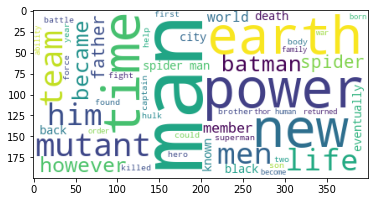

In [87]:
#Tf-idf Word Cloud 
feature_names = vectorizer.get_feature_names()
dense = history_tfidf.todense()
denselist = dense.tolist()
test = pd.DataFrame(denselist, columns=feature_names)

x = vectorizer.vocabulary_
Cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(test.T.sum(axis=1))
plt.imshow(Cloud)

In [92]:
#  create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']
tfidf.sort_values(by=['tfidf'], ascending=False).head(10)

,tfidf
finally able,5.632078
elsewhere,5.632078
surprisingly,5.632078
drunken,5.632078
due fact,5.632078
due lack,5.632078
supported,5.632078
superhumans,5.632078
egyptian,5.632078
elder universe,5.632078


In [89]:
#y = df['creator']#.to_numpy()
#X = df.loc[:, ['history_text', 'powers_text']]
# one hot encode our labels and features for prediction sake
le = LabelEncoder()
#oe = OneHotEncoder(sparse=False)

# integer_X = le.fit_transform(vectorizer.get_feature_names())
# integer_X = integer_X.reshape(len(integer_X), 1)
# onehot_X = oe.fit_transform(integer_X)

integer_y = le.fit_transform(y)
#integer_y = integer_y.reshape(len(integer_y), 1)
#onehot_y = oe.fit_transform(integer_y)


# get back the original labels
# inverted = le.inverse_transform([np.argmax(onehot_y[0])])
# this is how we'd get out the actual label names of the encoder
# for i in onehot_y:
#     print(le.inverse_transform([np.argmax(i)]))

history_tfidf = history_tfidf.toarray()
# create test and train set
X_train, X_test = train_test_split(
    history_tfidf,
    test_size=0.20,
    random_state=42069
)
y_train, y_test = train_test_split(
    integer_y,
    test_size=0.20,
    random_state=42069
)


In [90]:
X_test.shape

(226, 5831)

## Random Forest Model

In [ ]:
#Tuning Parameters 
# n_estimators : the number of trees in the forest of the model
# max_depth: maximum depth of each tree, dont touch
# min_samples_split: minimum number of samples required to split an internal leaf node.
# min_samples_leaf: minimum number of samples required to be at a leaf node.
#criterion{“gini”, “entropy”}, default=”gini”

In [69]:
param_grid = { 
    'n_estimators': [50, 300, 1000], #[100, 150, 200,.1000] #200 consistently the best
    'max_features': ['sqrt'],
    'criterion': ['gini']
}

In [70]:
rfc=RandomForestClassifier(random_state=545)

RF_grid = GridSearchCV(rfc, param_grid=param_grid)
RF_grid.fit(X_train, y_train)


GridSearchCV(estimator=RandomForestClassifier(random_state=545),
             param_grid={'criterion': ['gini'], 'max_features': ['sqrt'],
                         'n_estimators': [50, 300, 1000]})

In [71]:
RF_grid.best_params_


{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 300}

In [72]:
classifier = RandomForestClassifier(n_estimators = 300 ,random_state=545)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
from sklearn import metrics 
print()
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
#Need to beat 80.5% Accuracy (100 trees) in Tuning 


ACCURACY OF THE MODEL:  0.8141592920353983


In [73]:
name_mappings = dict(zip(le.classes_, le.transform(le.classes_)))
print(name_mappings)

{'dark horse comics': 0, 'dc comics': 1, 'george lucas': 2, 'image comics': 3, 'lego': 4, 'marvel comics': 5, 'nbc - heroes': 6, 'shueisha': 7}


In [74]:
 creators_list = ['dark horse comics','dc comics', 'george lucas','image comics','lego','marvel comics','nbc - heroes',  'shueisha', ]

In [75]:
prediction = le.inverse_transform(y_pred)
test  = le.inverse_transform(y_test)
confusion_matrix(y_test, y_pred)

array([[  0,   0,   0,   0,   0,   6,   0,   0],
       [  0,  71,   0,   0,   0,  16,   0,   0],
       [  0,   0,   0,   0,   0,   5,   0,   0],
       [  0,   0,   0,   0,   0,   3,   0,   0],
       [  0,   2,   0,   0,   1,   0,   0,   0],
       [  0,   5,   0,   0,   1, 108,   0,   0],
       [  0,   0,   0,   0,   0,   2,   1,   0],
       [  0,   1,   0,   0,   0,   1,   0,   3]])

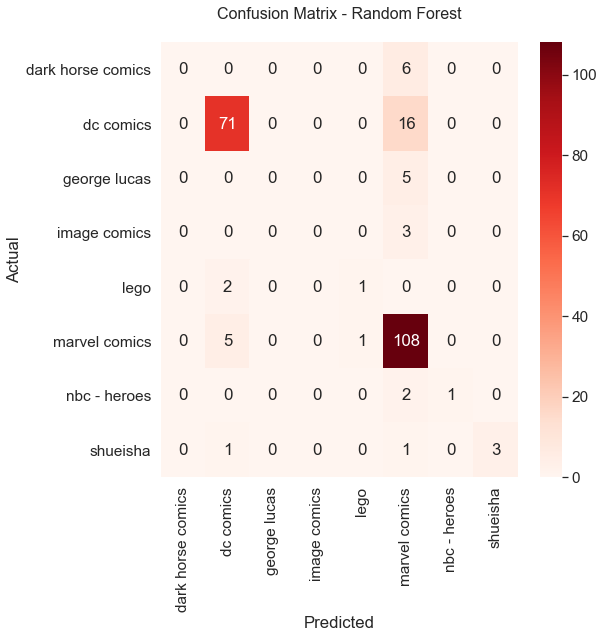

In [76]:
# Get and reshape confusion matrix data
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(test, prediction)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Reds", fmt='d',
            xticklabels=creators_list, 
            yticklabels=creators_list)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix - Random Forest\n", size=16);